In [138]:
import os
import random
import requests
import warnings
from datetime import datetime

import holidays
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import pickle


# Suppress warnings
warnings.filterwarnings('ignore')

# Statistical and ML libraries
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif

# Time series specific libraries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox


# Deep learning libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [42]:
# Define the file paths
path1 = r'C:\Users\LENOVO\MachineLearningProhects\TimeSeriesForecasting_End_To_End\data\timeseries_model_data.csv'
path2 = r'C:\Users\TPWODL\New folder_Content\TimeSeriesForecasting_End_To_End\data\timeseries_model_data.csv'

# Check which path exists and read CSV
if os.path.exists(path1):
    new_df = pd.read_csv(path1) 
elif os.path.exists(path2):
    new_df = pd.read_csv(path2)   
else:
    # Raise a FileNotFoundError if neither path is valid
    raise FileNotFoundError("❌ No valid data file found in either specified path.")

In [43]:
new_df.head(2)

,time,temp_max_C,precip_mm,day_of_week,month,wind_speed_max_m_s,Complaint_Count,year,relative_humidity_2m_mean,weather_label,Complaint_Count_diff1
0,2022-06-10,41.0,0.1,4,6,16.6,10,2022,47,1,NaN
1,2022-06-11,41.0,0.2,5,6,25.3,12,2022,42,1,2.0


In [44]:
new_df["time"] = pd.to_datetime(new_df["time"])


In [45]:
df = new_df.drop(columns=['relative_humidity_2m_mean','weather_label','month','year', 'Complaint_Count_diff1'])

In [46]:
df['day_of_month'] = df['time'].dt.day
df['day_of_year'] = df['time'].dt.dayofyear

In [47]:
df.set_index('time', inplace=True)

In [49]:
df.head(2)

,temp_max_C,precip_mm,day_of_week,wind_speed_max_m_s,Complaint_Count,day_of_month,day_of_year
time,,,,,,,
2022-06-10,41.0,0.1,4,16.6,10,10,161
2022-06-11,41.0,0.2,5,25.3,12,11,162


In [67]:
# Separate features (X) and target (y)
X = df.drop(columns=['Complaint_Count'])
y = df['Complaint_Count']
# Split data into train and test sets (80-20 split)
train_size = int(len(df) * 0.9)
y_train, y_test = y[:train_size], y[train_size:]
X_train, X_test = X[:train_size], X[train_size:]
# Print shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print(f"Training set size: {len(y_train)}")
print(f"Test set size: {len(y_test)}")
print(f"Date range - Train: {df.index[0]} to {df.index[train_size-1]}")
print(f"Date range - Test: {df.index[train_size]} to {df.index[-1]}")

X_train shape: (1064, 6)
X_test shape: (119, 6)
y_train shape: (1064,)
y_test shape: (119,)
Training set size: 1064
Test set size: 119
Date range - Train: 2022-06-10 00:00:00 to 2025-06-17 00:00:00
Date range - Test: 2025-06-18 00:00:00 to 2025-10-19 00:00:00


In [125]:
best_order = (1, 1, 1)
best_seasonal_order = (1, 1, 1, 7)

final_model = SARIMAX(
    endog=y_train,
    exog=X_train,
    order=best_order,
    seasonal_order=best_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit()

print(final_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                   Complaint_Count   No. Observations:                 1064
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -3909.751
Date:                           Fri, 31 Oct 2025   AIC                           7841.501
Time:                                   04:10:43   BIC                           7895.992
Sample:                                        0   HQIC                          7862.165
                                          - 1064                                         
Covariance Type:                             opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
temp_max_C             0.3352      0.161      2.086      0.037       0.020       0.650
precip_mm          

In [126]:
y_pred = final_model.predict(start=len(y_train),end=len(y_train) + len(y_test) - 1, exog=X_test)

# Combine results
forecast_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred.values,
}, index=y_test.index)

In [127]:
forecast_df.head(1)

,Actual,Predicted
time,,
2025-06-18,75,64.473237


In [128]:
# Ensure both y_test and y_pred are numpy arrays and aligned properly
y_true = np.array(y_test)
y_pred_values = np.array(y_pred)

# Core metrics
mae = mean_absolute_error(y_true, y_pred_values)
mse = mean_squared_error(y_true, y_pred_values)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred_values)

# Safe MAPE calculation (exclude zero or negative actuals)
non_zero_mask = y_true != 0
if np.any(non_zero_mask):  # Avoid division by zero
    mape = (np.abs((y_true[non_zero_mask] - y_pred_values[non_zero_mask]) / y_true[non_zero_mask]).mean()) * 100
else:
    mape = np.nan  # or handle gracefully

# Display
print("\n📊 Model Evaluation Metrics:")
print(f"MAE   : {mae:.4f}")
print(f"MSE   : {mse:.4f}")
print(f"RMSE  : {rmse:.4f}")
print(f"R²    : {r2:.4f}")
print(f"MAPE  : {mape:.2f}%")


📊 Model Evaluation Metrics:
MAE   : 19.1056
MSE   : 508.2381
RMSE  : 22.5441
R²    : -1.0414
MAPE  : 66.80%


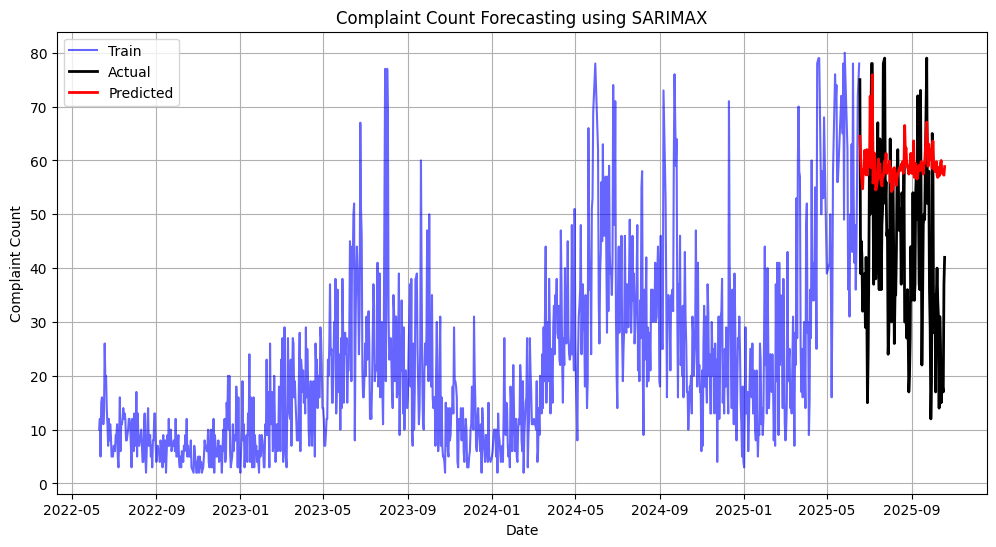

In [133]:
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label='Train', color='blue', alpha=0.6)
plt.plot(y_test.index, y_test, label='Actual', color='black', linewidth=2)
plt.plot(y_test.index, y_pred, label='Predicted', color='red', linewidth=2)
plt.title("Complaint Count Forecasting using SARIMAX")
plt.xlabel("Date")
plt.ylabel("Complaint Count")
plt.legend()
plt.grid(True)
plt.show()

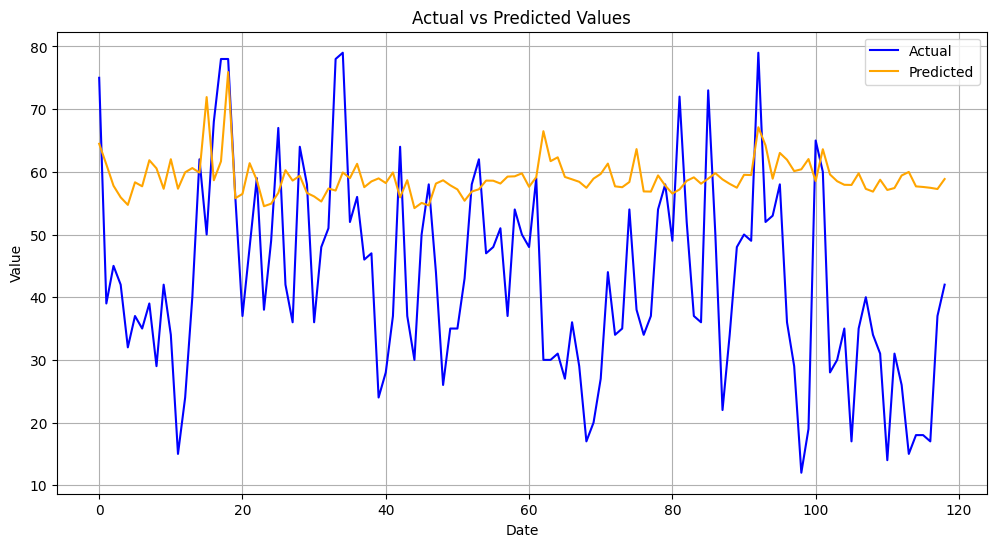

In [134]:
# SARIMAX Model Performance Visualization

# Ensure datetime index
y_test.index = pd.to_datetime(y_test.index)
y_pred.index = pd.to_datetime(y_pred.index)

y_true = np.array(y_test)
y_pred_values = np.array(y_pred)

# 1️⃣ Actual vs Predicted
plt.figure(figsize=(12,6))
plt.plot(y_true, label='Actual', color='blue')
plt.plot(y_pred_values, label='Predicted', color='orange')
plt.title("Actual vs Predicted Values")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

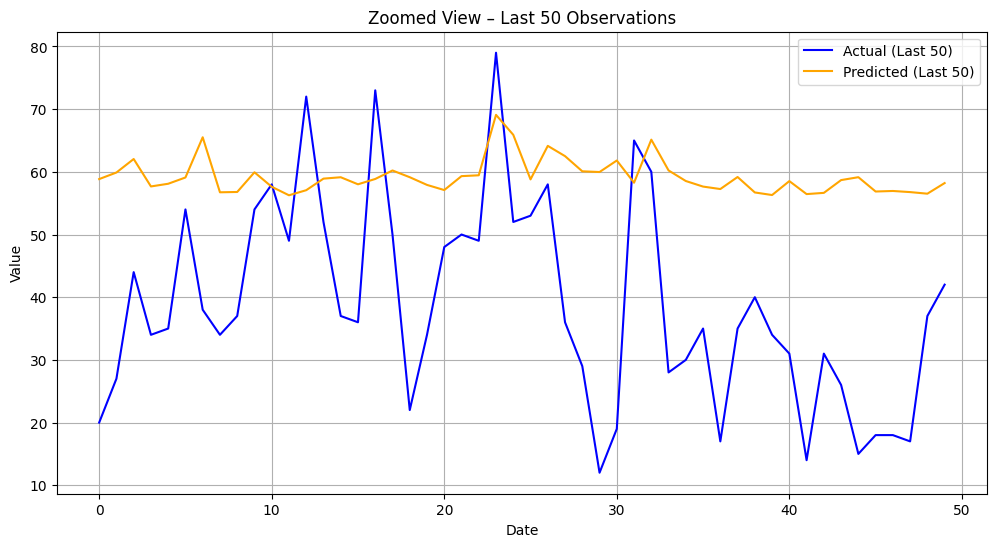

In [123]:
# 2️⃣ Zoomed-in Comparison (Last 50 points)
plt.figure(figsize=(12,6))
plt.plot(y_true[-50:], label='Actual (Last 50)', color='blue')
plt.plot(y_pred_values[-50:], label='Predicted (Last 50)', color='orange')
plt.title("Zoomed View – Last 50 Observations")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

In [135]:
# Model statistics
print(f"\n🎯 Model Statistics:")
print(f"  Training samples              : {len(y_train)}")
print(f"  Test samples                  : {len(y_test)}")
print(f"  AIC                           : {final_model.aic:.2f}")
print(f"  BIC                           : {final_model.bic:.2f}")


🎯 Model Statistics:
  Training samples              : 1064
  Test samples                  : 119
  AIC                           : 7841.50
  BIC                           : 7895.99


In [136]:
# 2. RESIDUALS ANALYSIS

print("\n" + "="*70)
print("📉 RESIDUALS ANALYSIS")
print("="*70)

residuals = y_true - y_pred_values

print(f"\n📊 Residuals Statistics:")
print(f"  Mean of residuals             : {np.mean(residuals):.6f}")
print(f"  Std Dev of residuals          : {np.std(residuals):.4f}")
print(f"  Min residual                  : {np.min(residuals):.4f}")
print(f"  Max residual                  : {np.max(residuals):.4f}")
print(f"  Skewness                      : {pd.Series(residuals).skew():.4f}")
print(f"  Kurtosis                      : {pd.Series(residuals).kurtosis():.4f}")


📉 RESIDUALS ANALYSIS

📊 Residuals Statistics:
  Mean of residuals             : -16.379906
  Std Dev of residuals          : 15.4899
  Min residual                  : -48.4022
  Max residual                  : 20.9835
  Skewness                      : 0.2496
  Kurtosis                      : -0.4716


In [139]:
# 3. DIAGNOSTIC TESTS (ASSUMPTIONS)


print("\n" + "="*70)
print("✅ DIAGNOSTIC TESTS (ASSUMPTIONS VALIDATION)")
print("="*70)

# Ljung-Box test for autocorrelation
print(f"\n🔍 Ljung-Box Test (Auto-correlation):")
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
lb_pvalue = lb_test['lb_pvalue'].values[0]
print(f"  Null Hypothesis: No auto-correlation in residuals")
print(f"  P-value: {lb_pvalue:.4f}")
if lb_pvalue > 0.05:
    print(f"  ✓ Result: PASSED - Residuals are independent (p > 0.05)")
else:
    print(f"  ✗ Result: FAILED - Auto-correlation detected (p < 0.05)")

# Normality test (Jarque-Bera via summary)
print(f"\n📊 Normality Test (from model summary):")
print(f"  Check final_model.summary() for Jarque-Bera test")
print(f"  Null Hypothesis: Residuals are normally distributed")

# Homoscedasticity visual check
print(f"\n⚖️ Homoscedasticity Test:")
print(f"  Visual inspection: Check residuals plot below")


✅ DIAGNOSTIC TESTS (ASSUMPTIONS VALIDATION)

🔍 Ljung-Box Test (Auto-correlation):
  Null Hypothesis: No auto-correlation in residuals
  P-value: 0.0000
  ✗ Result: FAILED - Auto-correlation detected (p < 0.05)

📊 Normality Test (from model summary):
  Check final_model.summary() for Jarque-Bera test
  Null Hypothesis: Residuals are normally distributed

⚖️ Homoscedasticity Test:
  Visual inspection: Check residuals plot below



📊 GENERATING PERFORMANCE VISUALIZATIONS


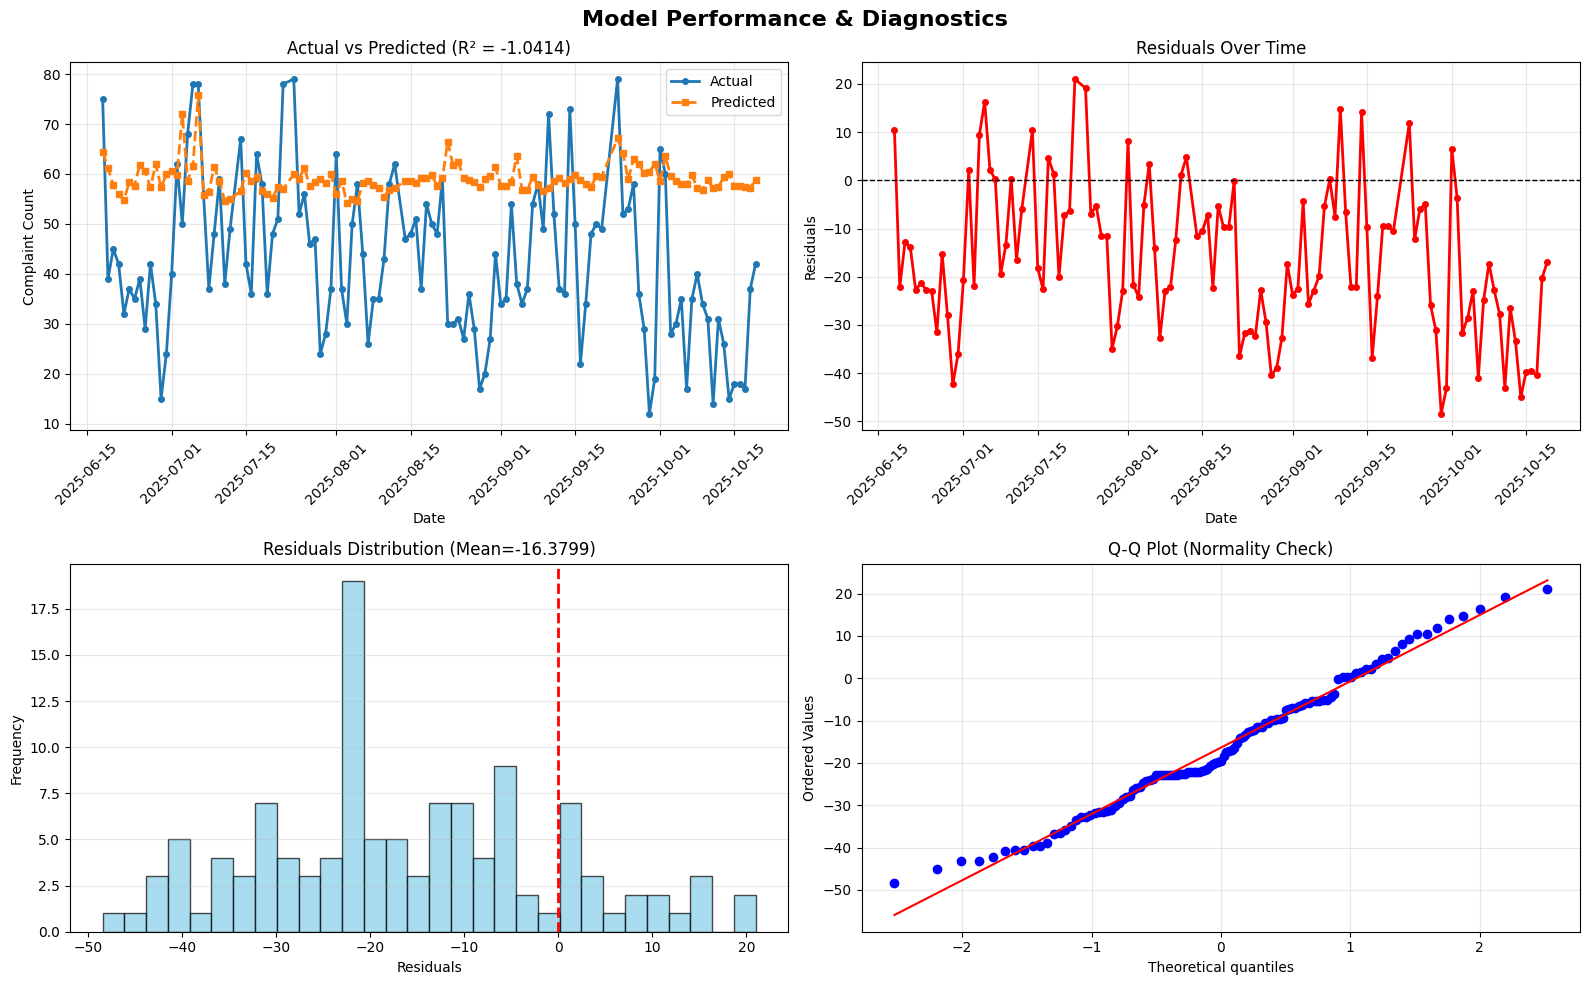

In [141]:
# 4. PERFORMANCE VISUALIZATION

print("\n" + "="*70)
print("📊 GENERATING PERFORMANCE VISUALIZATIONS")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Model Performance & Diagnostics', fontsize=16, fontweight='bold')

# Plot 1: Actual vs Predicted
axes[0, 0].plot(y_test.index, y_true, 'o-', label='Actual', linewidth=2, markersize=4)
axes[0, 0].plot(y_test.index, y_pred_values, 's--', label='Predicted', linewidth=2, markersize=4)
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Complaint Count')
axes[0, 0].set_title(f'Actual vs Predicted (R² = {r2:.4f})')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot 2: Residuals over time
axes[0, 1].plot(y_test.index, residuals, 'o-', color='red', linewidth=2, markersize=4)
axes[0, 1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residuals Over Time')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

# Plot 3: Residuals distribution
axes[1, 0].hist(residuals, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title(f'Residuals Distribution (Mean={np.mean(residuals):.4f})')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 4: Q-Q plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot (Normality Check)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


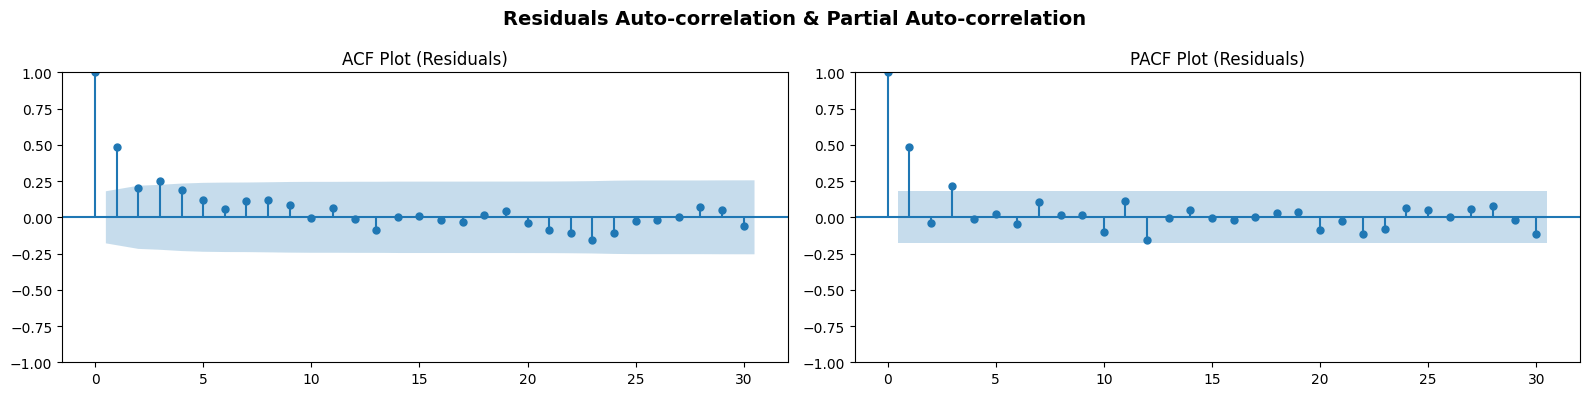

In [142]:
# 5. ACF & PACF PLOTS FOR RESIDUALS

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
fig.suptitle('Residuals Auto-correlation & Partial Auto-correlation', fontsize=14, fontweight='bold')

plot_acf(residuals, lags=30, ax=axes[0])
axes[0].set_title('ACF Plot (Residuals)')

plot_pacf(residuals, lags=30, ax=axes[1])
axes[1].set_title('PACF Plot (Residuals)')

plt.tight_layout()
plt.show()

In [143]:
# 6. ACTUAL VS PREDICTED DETAILED COMPARISON

print("\n" + "="*70)
print("📋 DETAILED PREDICTION RESULTS (First 10 & Last 10 samples)")
print("="*70)

comparison_df = pd.DataFrame({
    'Date': y_test.index,
    'Actual': y_true,
    'Predicted': y_pred_values,
    'Error': residuals,
    'Abs_Error': np.abs(residuals),
    'Pct_Error': (np.abs(residuals) / (y_true + 1e-5)) * 100
})

print("\n📊 First 10 Predictions:")
print(comparison_df.head(10).to_string(index=False))

print("\n📊 Last 10 Predictions:")
print(comparison_df.tail(10).to_string(index=False))


📋 DETAILED PREDICTION RESULTS (First 10 & Last 10 samples)

📊 First 10 Predictions:
      Date  Actual  Predicted      Error  Abs_Error  Pct_Error
2025-06-18      75  64.473237  10.526763  10.526763  14.035682
2025-06-19      39  61.186534 -22.186534  22.186534  56.888534
2025-06-20      45  57.780745 -12.780745  12.780745  28.401650
2025-06-21      42  55.930197 -13.930197  13.930197  33.167129
2025-06-22      32  54.725270 -22.725270  22.725270  71.016447
2025-06-23      37  58.331276 -21.331276  21.331276  57.652081
2025-06-24      35  57.691107 -22.691107  22.691107  64.831716
2025-06-25      39  61.850607 -22.850607  22.850607  58.591285
2025-06-26      29  60.551180 -31.551180  31.551180 108.797133
2025-06-27      42  57.296787 -15.296787  15.296787  36.420913

📊 Last 10 Predictions:
      Date  Actual  Predicted      Error  Abs_Error  Pct_Error
2025-10-10      31  58.739007 -27.739007  27.739007  89.480638
2025-10-11      14  57.107561 -43.107561  43.107561 307.910931
2025-10-1

In [144]:
# 7. FUTURE FORECAST (30 DAYS)

# Get the last known exogenous variables pattern
last_exog = X_test.iloc[-1:].values
exog_future = np.tile(last_exog, (30, 1))

In [148]:
# Generate future forecast
future_forecast = final_model.get_forecast(steps=30, exog=exog_future)
future_pred = future_forecast.predicted_mean
future_conf_int = future_forecast.conf_int(alpha=0.05)

In [149]:
# Create future dates
last_date = y_test.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')

# Create forecast dataframe
forecast_30d = pd.DataFrame({
    'Date': future_dates,
    'Forecast': future_pred.values,
    'Lower_95%': future_conf_int.iloc[:, 0].values,
    'Upper_95%': future_conf_int.iloc[:, 1].values,
    'Confidence_Width': (future_conf_int.iloc[:, 1] - future_conf_int.iloc[:, 0]).values
})

print("\n📊 30-Day Forecast:")
print(forecast_30d.to_string(index=False))


📊 30-Day Forecast:
      Date  Forecast  Lower_95%  Upper_95%  Confidence_Width
2025-10-20 58.492514  38.774280  78.210748         39.436468
2025-10-21 55.637729  34.753426  76.522031         41.768606
2025-10-22 52.561806  31.382842  73.740769         42.357927
2025-10-23 52.165622  30.822698  73.508546         42.685848
2025-10-24 52.203866  30.725314  73.682419         42.957105
2025-10-25 52.638956  31.032273  74.245640         43.213367
2025-10-26 53.841018  32.108662  75.573375         43.464713
2025-10-27 53.590152  31.717771  75.462532         43.744761
2025-10-28 54.583187  32.581948  76.584427         44.002479
2025-10-29 52.516429  30.389613  74.643244         44.253631
2025-10-30 52.382448  30.131485  74.633411         44.501926
2025-10-31 52.490817  30.116587  74.865047         44.748460
2025-11-01 52.947964  30.451193  75.444735         44.993542
2025-11-02 54.155300  31.536665  76.773936         45.237271
2025-11-03 53.903564  31.148405  76.658724         45.510319
2025

In [150]:
# Summary statistics
print(f"\n📈 Forecast Summary:")
print(f"  Average forecast value        : {forecast_30d['Forecast'].mean():.4f}")
print(f"  Min forecast value            : {forecast_30d['Forecast'].min():.4f}")
print(f"  Max forecast value            : {forecast_30d['Forecast'].max():.4f}")
print(f"  Std Dev of forecast           : {forecast_30d['Forecast'].std():.4f}")


📈 Forecast Summary:
  Average forecast value        : 53.7390
  Min forecast value            : 52.1656
  Max forecast value            : 58.4925
  Std Dev of forecast           : 1.3591


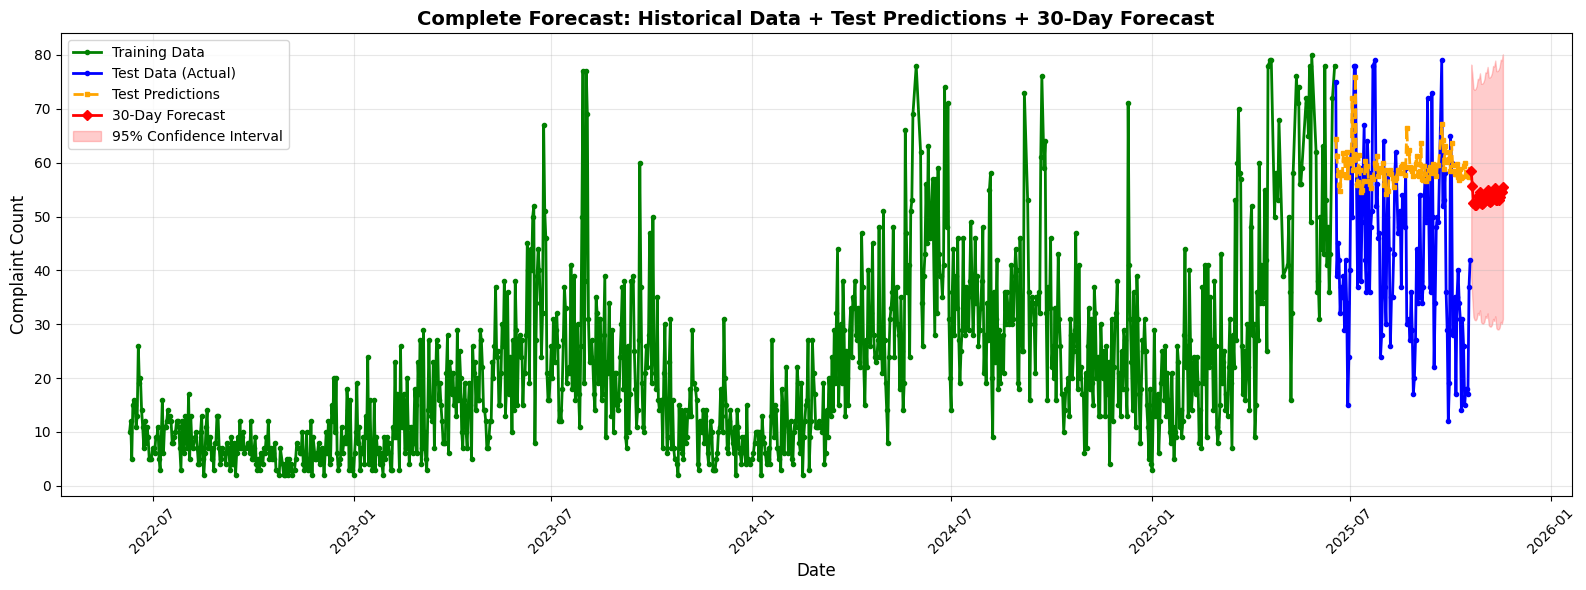

In [151]:
# 8. FORECAST VISUALIZATION


fig, ax = plt.subplots(figsize=(16, 6))

# Historical data
ax.plot(y_train.index, y_train.values, 'o-', label='Training Data', linewidth=2, color='green', markersize=3)
ax.plot(y_test.index, y_test.values, 'o-', label='Test Data (Actual)', linewidth=2, color='blue', markersize=3)

# Test predictions
ax.plot(y_test.index, y_pred_values, 's--', label='Test Predictions', linewidth=2, color='orange', markersize=3)

# Future forecast
ax.plot(forecast_30d['Date'], forecast_30d['Forecast'], 'D-', label='30-Day Forecast', 
        linewidth=2, color='red', markersize=5)

# Confidence interval
ax.fill_between(forecast_30d['Date'], 
                forecast_30d['Lower_95%'], 
                forecast_30d['Upper_95%'], 
                alpha=0.2, color='red', label='95% Confidence Interval')

# Formatting
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Complaint Count', fontsize=12)
ax.set_title('Complete Forecast: Historical Data + Test Predictions + 30-Day Forecast', 
             fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [153]:
# 9. SUMMARY REPORT

print("\n" + "="*70)
print("📋 FINAL SUMMARY REPORT")
print("="*70)

print(f"""
✓ Model Type: SARIMAX{best_order}x{best_seasonal_order}
✓ Training Samples: {len(y_train)}
✓ Test Samples: {len(y_test)}
✓ Forecast Period: 30 days

📊 PERFORMANCE METRICS:
  • R² Score: {r2:.4f} (0-1, higher is better)
  • RMSE: {rmse:.4f} ({rmse:.2f}% of mean)
  • MAE: {mae:.4f}
  • MAPE: {mape:.2f}%

✅ ASSUMPTIONS:
  • Ljung-Box Test (p={lb_pvalue:.4f}): {'✓ PASSED' if lb_pvalue > 0.05 else '✗ FAILED'}
  • Residuals Mean ≈ 0: {np.mean(residuals):.6f} ✓
  • Normality: Check Q-Q plot
  • Stationarity: Included in model

🔮 30-DAY FORECAST:
  • Average Predicted Value: {forecast_30d['Forecast'].mean():.4f}
  • Forecast Range: {forecast_30d['Forecast'].min():.4f} to {forecast_30d['Forecast'].max():.4f}
  • Confidence Interval: 95%

📌 Next Steps:
  1. Monitor actual vs forecasted values
  2. Retrain model with new data weekly
  3. Adjust parameters if performance degrades
""")

print("="*70)
print("✓ Analysis Complete!")
print("="*70)


📋 FINAL SUMMARY REPORT

✓ Model Type: SARIMAX(1, 1, 1)x(1, 1, 1, 7)
✓ Training Samples: 1064
✓ Test Samples: 119
✓ Forecast Period: 30 days

📊 PERFORMANCE METRICS:
  • R² Score: -1.0414 (0-1, higher is better)
  • RMSE: 22.5441 (22.54% of mean)
  • MAE: 19.1056
  • MAPE: 66.80%

✅ ASSUMPTIONS:
  • Ljung-Box Test (p=0.0000): ✗ FAILED
  • Residuals Mean ≈ 0: -16.379906 ✓
  • Normality: Check Q-Q plot
  • Stationarity: Included in model

🔮 30-DAY FORECAST:
  • Average Predicted Value: 53.7390
  • Forecast Range: 52.1656 to 58.4925
  • Confidence Interval: 95%

📌 Next Steps:
  1. Monitor actual vs forecasted values
  2. Retrain model with new data weekly
  3. Adjust parameters if performance degrades

✓ Analysis Complete!
